In [152]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

# Importing Data

In [153]:
import json
from pandas.io.json import json_normalize

# raw_data = pd.read_json("json/data.json", orient="records") ; works but fewer columns

# Normalizing columns lets us get info from sub-arrays like 'share.link' and 'share.share_text'
with open('andrews_original_formatted.json') as data_file:    
    raw_data = json_normalize(json.load(data_file))

raw_data.columns

Index(['content', 'reactions', 'sender_name', 'timestamp'], dtype='object')

In [154]:
raw_data['sender_name'].value_counts()

Joyce Luong     62943
Andrew Huang    51671
Name: sender_name, dtype: int64

In [155]:
raw_data.head()

,content,reactions,sender_name,timestamp
0,Ok I guess I can download it on mine lol,"[{'actor': 'Joyce Luong', 'reaction': '😍'}]",Andrew Huang,"Sep 19, 2018 6:01pm"
1,It’s empty,[],Joyce Luong,"Sep 19, 2018 6:00pm"
2,It won’t pull,[],Joyce Luong,"Sep 19, 2018 6:00pm"
3,Seems like a thing to try,[],Andrew Huang,"Sep 19, 2018 6:00pm"
4,And pull it,[],Andrew Huang,"Sep 19, 2018 6:00pm"


In [156]:
def decode_emoji(emoji):
    # UTF8 emojis were incorrectly exported as Latin-1.
    return emoji.encode('latin1').decode('utf8')

def parse_reactions(r): 
    """ Parses and returns the reactions for a conversation between exactly two people.
    
    INPUT:  [{'reaction': 'ð\x9f\x91\x8e', 'actor': 'Name1'},
            {'reaction': 'ð\x9f\x98¢', 'actor': 'Name2'}]
            
    OUTPUT: "Name1", 😮, "Name2", 😍
    """
    if len(r) == 0:
        return None, None, None, None
    
    elif len(r) == 1:
        return r[0]['actor'], r[0]['reaction'], None, None

    else:
        return r[0]['actor'], r[0]['reaction'], r[1]['actor'], r[1]['reaction']

In [157]:
# parse reaction data
raw_data['actor1'], raw_data['reaction1'], raw_data['actor2'], raw_data['reaction2'] = \
    zip(*raw_data['reactions'].map(parse_reactions))

raw_data.head(3)

,content,reactions,sender_name,timestamp,actor1,reaction1,actor2,reaction2
0,Ok I guess I can download it on mine lol,"[{'actor': 'Joyce Luong', 'reaction': '😍'}]",Andrew Huang,"Sep 19, 2018 6:01pm",Joyce Luong,😍,None,None
1,It’s empty,[],Joyce Luong,"Sep 19, 2018 6:00pm",None,None,None,None
2,It won’t pull,[],Joyce Luong,"Sep 19, 2018 6:00pm",None,None,None,None


In [158]:
raw_data['timestamp'] = pd.to_datetime(raw_data['timestamp'])
raw_data.head()

,content,reactions,sender_name,timestamp,actor1,reaction1,actor2,reaction2
0,Ok I guess I can download it on mine lol,"[{'actor': 'Joyce Luong', 'reaction': '😍'}]",Andrew Huang,2018-09-19 18:01:00,Joyce Luong,😍,None,None
1,It’s empty,[],Joyce Luong,2018-09-19 18:00:00,None,None,None,None
2,It won’t pull,[],Joyce Luong,2018-09-19 18:00:00,None,None,None,None
3,Seems like a thing to try,[],Andrew Huang,2018-09-19 18:00:00,None,None,None,None
4,And pull it,[],Andrew Huang,2018-09-19 18:00:00,None,None,None,None


# Initial Impressions

In [159]:
# only look at 'generic' messages
# data = raw_data[raw_data['type'] == 'Generic'].copy()

# print("NOTE: Lost these many non-generic rows: {} or {}%". \
#      format(len(raw_data) - len(data), round(100*(len(raw_data) - len(data))/len(raw_data), 3)))

# slice out columns of interest
data = raw_data.loc[:, ['sender_name', 'timestamp', 'content', 'actor1', 'reaction1', 'actor2', 'reaction2']]

data.head()

,sender_name,timestamp,content,actor1,reaction1,actor2,reaction2
0,Andrew Huang,2018-09-19 18:01:00,Ok I guess I can download it on mine lol,Joyce Luong,😍,None,None
1,Joyce Luong,2018-09-19 18:00:00,It’s empty,None,None,None,None
2,Joyce Luong,2018-09-19 18:00:00,It won’t pull,None,None,None,None
3,Andrew Huang,2018-09-19 18:00:00,Seems like a thing to try,None,None,None,None
4,Andrew Huang,2018-09-19 18:00:00,And pull it,None,None,None,None


## Number of Messages Sent Per Person

In [160]:
data['sender_name'].value_counts()

Joyce Luong     62943
Andrew Huang    51671
Name: sender_name, dtype: int64

In [168]:
#data['month'] = data['timestamp'].dt.month
#data['hour'] = data['timestamp'].dt.hour
data['date'] = data['timestamp'].dt.strftime('%a, %b %d, %Y @ %r')
data['year_month'] = data['timestamp'].dt.strftime('%Y-%m')
data.head(5)

,sender_name,timestamp,content,actor1,reaction1,actor2,reaction2,date,year_month
0,Andrew Huang,2018-09-19 18:01:00,Ok I guess I can download it on mine lol,Joyce Luong,😍,None,None,"Wed, Sep 19, 2018 @ 06:01:00 PM",2018-09
1,Joyce Luong,2018-09-19 18:00:00,It’s empty,None,None,None,None,"Wed, Sep 19, 2018 @ 06:00:00 PM",2018-09
2,Joyce Luong,2018-09-19 18:00:00,It won’t pull,None,None,None,None,"Wed, Sep 19, 2018 @ 06:00:00 PM",2018-09
3,Andrew Huang,2018-09-19 18:00:00,Seems like a thing to try,None,None,None,None,"Wed, Sep 19, 2018 @ 06:00:00 PM",2018-09
4,Andrew Huang,2018-09-19 18:00:00,And pull it,None,None,None,None,"Wed, Sep 19, 2018 @ 06:00:00 PM",2018-09


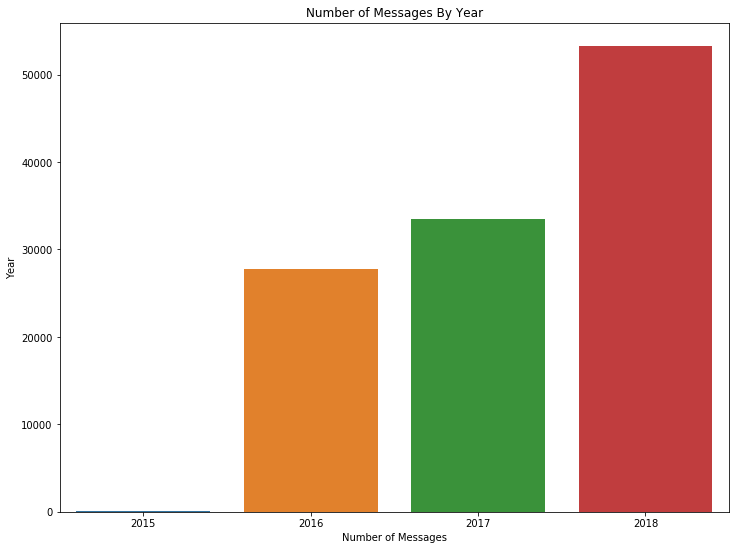

In [162]:
ax = sns.countplot(data['timestamp'].dt.year)
ax.set_ylabel("Year")
ax.set_xlabel("Number of Messages")
ax.set_title("Number of Messages By Year");

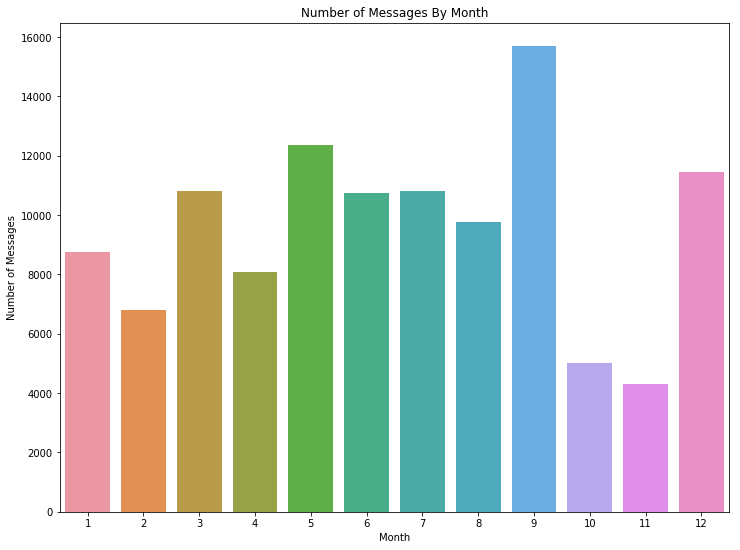

In [163]:
ax = sns.countplot(data['timestamp'].dt.month)
ax.set_xlabel("Month")
ax.set_ylabel("Number of Messages")
ax.set_title("Number of Messages By Month");

In [164]:
ax = sns.countplot(x='hour',hue='sender_name',data=data)
ax.set_title("Number of Messages By Hour");

ValueError: Could not interpret input 'hour'

In [ ]:
year_month = sorted(data['year_month'].unique()) # order to display the x-axis
ax = sns.countplot(x='year_month', hue='sender_name', data=data, order=year_month)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Number of Messages By Month");

In [ ]:
count_chars = lambda row: sum([len(message) for message in row])

reduced = data.loc[:, ['year_month', 'sender_name', 'content']]
char_len = reduced.groupby([reduced['year_month'], reduced['sender_name']]).agg(count_chars)

char_len.reset_index(inplace=True)

In [ ]:
ax = sns.barplot(x='year_month', y='content', hue='sender_name', data=char_len)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Character Count by Month");
ax.set_ylabel("Characters")
ax.set_xlabel("Month");

In [165]:
data.head()

,sender_name,timestamp,content,actor1,reaction1,actor2,reaction2
0,Andrew Huang,2018-09-19 18:01:00,Ok I guess I can download it on mine lol,Joyce Luong,😍,None,None
1,Joyce Luong,2018-09-19 18:00:00,It’s empty,None,None,None,None
2,Joyce Luong,2018-09-19 18:00:00,It won’t pull,None,None,None,None
3,Andrew Huang,2018-09-19 18:00:00,Seems like a thing to try,None,None,None,None
4,Andrew Huang,2018-09-19 18:00:00,And pull it,None,None,None,None


In [166]:
data.to_csv('corrected_html.csv', index=False)